## Hybrid simulation of the stochastic SIR model

The SIR model of epidemiology partitions the population into three compartments: susceptibles, S, who can catch the disease; infectives, I, who have already caught the disease and infect susceptibles; and recovered individuals, R. Since the disease is assumed not to be fatal, the sum $N=S+I+R$ remains constant. The rate at which the susceptibles get infected is 
$$
\lambda(t) = \frac{\beta I}{N}
$$
where the parameter $\beta$ is the probability of infection on contact. The infected individuals recover from the disease at a rate $\gamma$.

While stochastic simulations of this model can be rather slow for large population numbers, stochastic effects are also less rather relevant when population numbers are large.

The *hybrid method* for stochastic simulation of the SIR model exploits this, by
* simulating the stochastic dynamics if any of the population numbers is below a given threshold, and
* simulating the deterministic dynamics if all population numbers are above a given threshold.

The present example creates realisations for stochastic trajectories using this algorithm. For $200$ stochastic trajectories, the mean and variance of the observed trajectories for the number of infectives is calculated, plotted as a function of time, and compared to results from the corresponding fully-stochastic SIR model.

In [1]:
%matplotlib inline
import numpy as np
import pyross
import matplotlib.pyplot as plt
from timeit import default_timer as timer
#from matplotlib import rc; rc('text', usetex=True)

### Simulation of a single stochastic trajectory

In [2]:
M = 1                  # the SIR model has no age structure
Ni = 20000*np.ones(M)   # so there is only one age group 
N = np.sum(Ni)         # and the total population is the size of this age group

beta  = 0.2            # infection rate 
gIa   = 0.1            # recovery rate of asymptomatic infectives 
gIs   = 0.1            # recovery rate of symptomatic infectives 
alpha = 0              # fraction of asymptomatic infectives 
fsa   = 1              # the self-isolation parameter 


Ia0 = np.array([0])     # the SIR model has only one kind of infective 
Is0 = np.array([10])     # we take these to be symptomatic 
R0  = np.array([0])     # and assume there are no recovered individuals initially 
S0  = N-(Ia0+Is0+R0)    # so that the initial susceptibles are obtained from S + Ia + Is + R = N

# there is no contact structure
def contactMatrix(t):   
    return np.identity(M) 

# duration of simulation and data file
Tf = 160;  Nt=160; 


# threshold values
# note that these values are just for demonstration, and in practice
# are too low to assume that stochastic effects become irrelevant
Ias = np.array([0])
Iss = np.array([1000])
Ss = np.array([1000])

# if the simulation is in the stochastic mode and all numbers pass
# the following threshold, the simulation switches to deterministic dynamics
thresholds_from_below = (Ss,Ias,Iss)

# if the simulation is in the deterministic mode and all numbers pass
# the following threshold, the simulation switches to stochastic dynamics
Ias2 = np.array([0])
Iss2 = np.array([500])
Ss2 = np.array([1000])
thresholds_from_above = (Ss2,Ias2,Iss2)

thresholds = {'from_below':thresholds_from_below,
             'from_above':thresholds_from_above}

# instantiate model
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
model = pyross.hybrid.SIR(parameters, M, Ni)

# simulate model 
data = model.simulate(S0, Ia0, Is0, contactMatrix, Tf, thresholds)

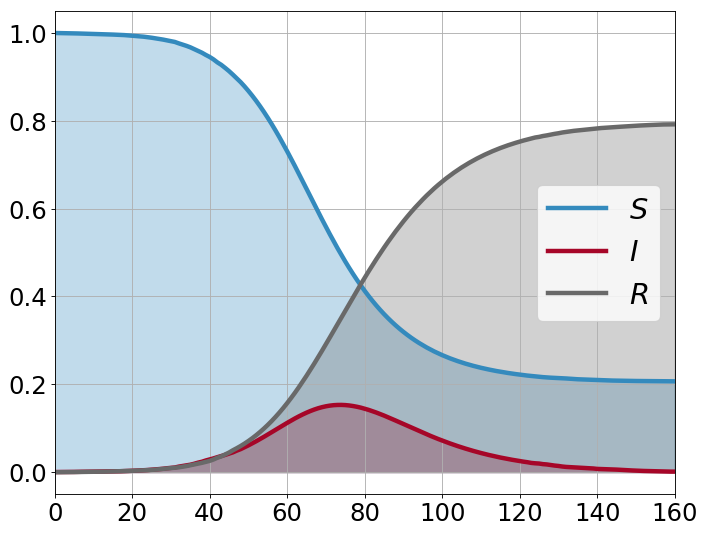

In [3]:
# plot the data and obtain the stochastic epidemic curve
S  = data['X'][:,0].flatten()
Ia = data['X'][:,1].flatten()
Is = data['X'][:,2].flatten()
t = data['t']


fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})


plt.fill_between(t, 0, S/N, color="#348ABD", alpha=0.3)
plt.plot(t, S/N, '-', color="#348ABD", label='$S$', lw=4)

plt.fill_between(t, 0, Is/N, color='#A60628', alpha=0.3)
plt.plot(t, Is/N, '-', color='#A60628', label='$I$', lw=4)

R=N-S-Ia-Is; plt.fill_between(t, 0, R/N, color="dimgrey", alpha=0.3)
plt.plot(t, R/N, '-', color="dimgrey", label='$R$', lw=4)

plt.legend(fontsize=26); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)

### Averaging over several simulations

If the simulation is run many times, mean and standard deviation of the resulting trajectories can be calculated.

In [4]:
# run 100 simulations, calculate mean and standard deviation

N_runs = 100

trajectories_h = np.zeros([N_runs,Nt+1,3],dtype=float)
start_h = timer()
for i in range(N_runs):
    print("Simulating trajectory {0} of {1}".format(i+1,N_runs),end='\r')
    cur_result = model.simulate(S0, Ia0, Is0, contactMatrix, Tf, thresholds) 
    trajectories_h[i] = cur_result['X']
end_h = timer()
print("{0} simulations finished in {1:3.2f} seconds".format(N_runs,end_h-start_h))
t_h = cur_result['t']
mean_h = np.mean(trajectories_h,axis=0)
std_h = np.std(trajectories_h,axis=0)

100 simulations finished in 19.48 seconds


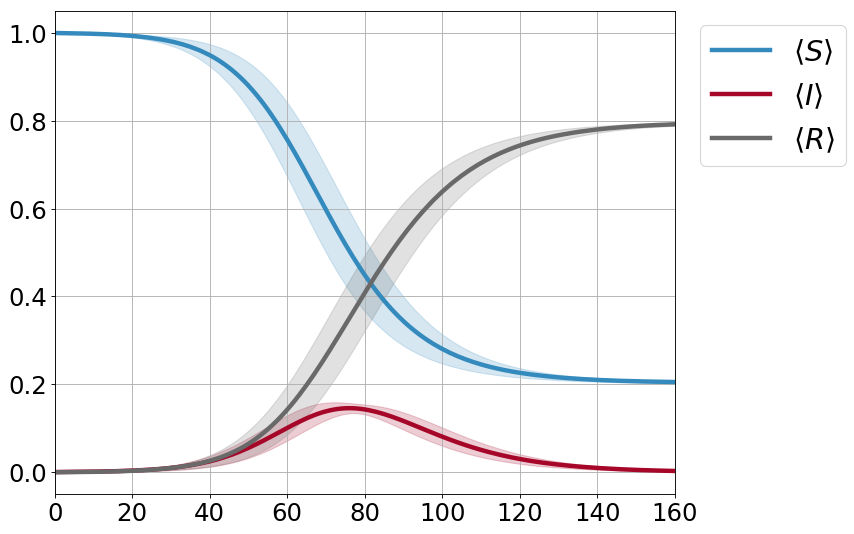

In [5]:
# plot mean and standard deviation

S_h  = mean_h[:,0].flatten()
Ia_h = mean_h[:,1].flatten()
Is_h = mean_h[:,2].flatten()
dS_h = std_h[:,0].flatten()
dIa_h = std_h[:,1].flatten()
dIs_h = std_h[:,2].flatten()
# for the recovered, we still need to calculate mean and variance
R_h_trajectories = N - trajectories_h[:,:,0] - trajectories_h[:,:,1] - trajectories_h[:,:,2]
R_h = np.mean(R_h_trajectories,axis=0)
dR_h = np.std(R_h_trajectories,axis=0)


fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})

# hybrid
plt.fill_between(t_h,(S_h - dS_h)/N,(S_h + dS_h)/N,color="#348ABD", alpha=0.2)
plt.plot(t_h, S_h/N, '-', color="#348ABD", label=r'$\langle S\rangle$', lw=4)
plt.fill_between(t_h,(Is_h - dIs_h)/N,(Is_h + dIs_h)/N,color="#A60628", alpha=0.2)
plt.plot(t_h, Is_h/N, '-', color="#A60628", label=r'$\langle I\rangle$', lw=4)
plt.fill_between(t_h,(R_h - dR_h)/N,(R_h + dR_h)/N,color="dimgrey", alpha=0.2)
plt.plot(t_h, R_h/N, '-', color="dimgrey", label=r'$\langle R\rangle $', lw=4)


plt.legend(fontsize=26,loc='upper right',bbox_to_anchor=(1.3,1)); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)

While the solid lines denote the instantaneous means, the colored shaded regions denote the standard deviation of the samples from the instantaneous mean.

### Comparison of the results from the hybrid simulations with averages over stochastic simulations

We now show that running fully stochastic simulations yields the same mean as obtained from the hybrid simulations, and compare the respective times needed for the simulations.

*Note: The following cell might take some time to evaluate.*

In [6]:
# for comparison, we also evaluate the deterministic SIR model
model_s = pyross.stochastic.SIR(parameters, M, Ni)

trajectories_s = np.zeros([N_runs,Nt+1,3],dtype=float)
start_s = timer()
for i in range(N_runs):
    print("Simulating trajectory {0} of {1}".format(i+1,N_runs),end='\r')
    cur_result = model_s.simulate(S0, Ia0, Is0, contactMatrix, Tf, Nt) 
    trajectories_s[i] = cur_result['X']
end_s = timer()
print("{0} simulations finished in {1:3.2f} seconds".format(N_runs,end_s-start_s))
t_s = cur_result['t']
mean_s = np.mean(trajectories_s,axis=0)
std_s = np.std(trajectories_s,axis=0)

S_s  = mean_s[:,0].flatten()
Ia_s = mean_s[:,1].flatten()
Is_s = mean_s[:,2].flatten()
dS_s = std_s[:,0].flatten()
dIa_s = std_s[:,1].flatten()
dIs_s = std_s[:,2].flatten()
# for the recovered, we still need to calculate mean and variance
R_s_trajectories = N - trajectories_s[:,:,0] - trajectories_s[:,:,1] - trajectories_s[:,:,2]
R_s = np.mean(R_s_trajectories,axis=0)
dR_s = np.std(R_s_trajectories,axis=0)

100 simulations finished in 59.72 seconds


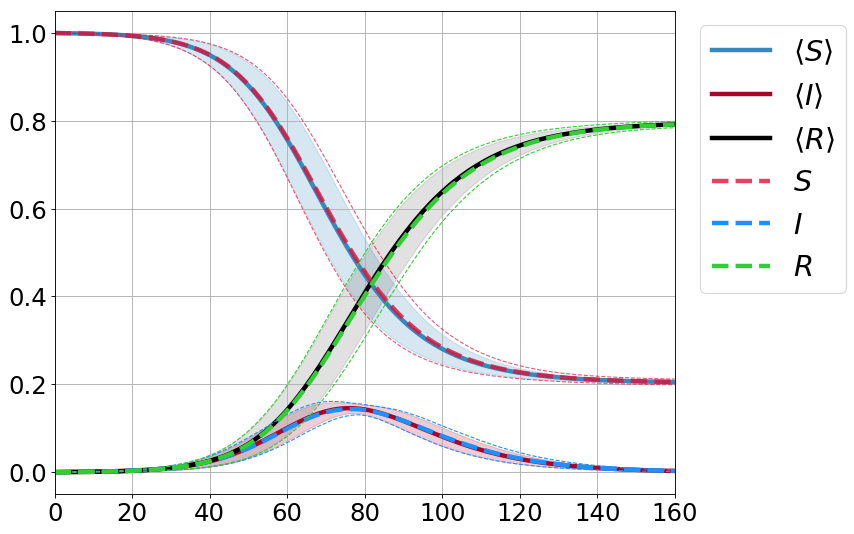

In [7]:
# compare hybrid and fully stochastic model

fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})

# hybrid
plt.fill_between(t_h,(S_h - dS_h)/N,(S_h + dS_h)/N,color="#348ABD", alpha=0.2)
plt.plot(t_h, S_h/N, '-', color="#348ABD", label=r'$\langle S\rangle$', lw=4)
plt.fill_between(t_h,(Is_h - dIs_h)/N,(Is_h + dIs_h)/N,color="#A60628", alpha=0.2)
plt.plot(t_h, Is_h/N, '-', color="#A60628", label=r'$\langle I\rangle$', lw=4)
plt.fill_between(t_h,(R_h - dR_h)/N,(R_h + dR_h)/N,color="dimgrey", alpha=0.2)
plt.plot(t_h, R_h/N, '-', color="black", label=r'$\langle R\rangle $', lw=4)

# stochastic
plt.plot(t_s, S_s/N, '--', color="crimson", label='$S$', lw=4,alpha=0.8)
plt.plot(t_s, (S_s-dS_s)/N, '--', color="crimson", lw=1,alpha=0.7)
plt.plot(t_s, (S_s+dS_s)/N, '--', color="crimson", lw=1,alpha=0.7)
plt.plot(t_s, Is_s/N, '--', color='dodgerblue', label='$I$', lw=4)
plt.plot(t_s, (Is_s-dIs_s)/N, '--', color='dodgerblue',  lw=1)
plt.plot(t_s, (Is_s+dIs_s)/N, '--', color='dodgerblue',  lw=1)
plt.plot(t_s, R_s/N, '--', color="limegreen", label='$R$', lw=4)
plt.plot(t_s, (R_s-dR_s)/N, '--', color="limegreen",  lw=1)
plt.plot(t_s, (R_s+dR_s)/N, '--', color="limegreen",  lw=1)

plt.legend(fontsize=26,loc='upper right',bbox_to_anchor=(1.3,1)); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)

The dashed colored lines denotes the mean and corresponding standard deviation obtained from the stochastic SIR model. As can be seen, the results from hybrid- and stochastic method are almost identical. For larger systems, and using larger thresholds in the hybrid method, the differences between hybrid method and fully stochastic simulations will be smaller.

Note that while the means plotted above are almost identical, the times needed to calculate these curves are not:

In [8]:
print("Hybrid method needed {0:3.2f} seconds".format(end_h-start_h))
print("Stochastic method needed {0:3.2f} seconds".format(end_s-start_s))
print("Speedup-factor obtained from using hybrid method = {0:3.2f}".format((end_s-start_s)/(end_h-start_h)))

Hybrid method needed 19.48 seconds
Stochastic method needed 59.72 seconds
Speedup-factor obtained from using hybrid method = 3.07
